<a href="https://colab.research.google.com/github/midhunreddy0607-eng/FMML_Project_and_Labs/blob/main/STP_AIML_Module_5_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 5 Project: Regression analysis on a COVID-dataset


In this project, we will use the concepts of regression and regularization we have learnt to predict early Covid-19 cases. We shall use linear regression, polynomial regression and ridge regression to obtain a reasonably good estimate of the future cases. Try experimenting with hyperparameters to obtain better results.

## Data Analysis

### 1. **Load the data** into a pandas dataframe.

In [ ]:
# Imports
import pandas as pd
import numpy  as np
import scipy.integrate

from matplotlib import pyplot as plt
plt.style.use('ggplot')
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 8

import copy
from   sklearn.metrics       import mean_squared_error, mean_absolute_error
from   sklearn.linear_model  import LinearRegression, BayesianRidge
from   sklearn.tree          import DecisionTreeRegressor
from   sklearn.preprocessing import PolynomialFeatures

In [ ]:
path = "https://raw.githubusercontent.com/PranavTadimeti/Regression_Project/main/covid_19_data.csv"
df_orig = pd.read_csv(path)
print(df_orig)

         SNo ObservationDate Province/State  Country/Region  \
0          1      01/22/2020          Anhui  Mainland China   
1          2      01/22/2020        Beijing  Mainland China   
2          3      01/22/2020      Chongqing  Mainland China   
3          4      01/22/2020         Fujian  Mainland China   
4          5      01/22/2020          Gansu  Mainland China   
...      ...             ...            ...             ...   
10666  10667      03/31/2020        Wyoming              US   
10667  10668      03/31/2020       Xinjiang  Mainland China   
10668  10669      03/31/2020          Yukon          Canada   
10669  10670      03/31/2020         Yunnan  Mainland China   
10670  10671      03/31/2020       Zhejiang  Mainland China   

               Last Update  Confirmed  Deaths  Recovered  
0          1/22/2020 17:00        1.0     0.0        0.0  
1          1/22/2020 17:00       14.0     0.0        0.0  
2          1/22/2020 17:00        6.0     0.0        0.0  
3      

### 2. Create a new dataframe which counts the cumulative total number of cases, the cumulative total number of deaths, and also  cumulative total number of recoveries for each date.

In [ ]:
import pandas as pd

# Example dataset
data = {
    'date': ['2020-01-01','2020-01-01','2020-01-02','2020-01-02','2020-01-03'],
    'cases': [10, 5, 20, 15, 30],
    'deaths': [1, 0, 2, 1, 3],
    'recoveries': [0, 2, 5, 3, 10]
}

df = pd.DataFrame(data)

# Step 1: Aggregate totals per date
daily_totals = df.groupby('date').sum().reset_index()

# Step 2: Compute cumulative totals
daily_totals['cumulative_cases'] = daily_totals['cases'].cumsum()
daily_totals['cumulative_deaths'] = daily_totals['deaths'].cumsum()
daily_totals['cumulative_recoveries'] = daily_totals['recoveries'].cumsum()

print(daily_totals)


         date  cases  deaths  recoveries  cumulative_cases  cumulative_deaths  \
0  2020-01-01     15       1           2                15                  1   
1  2020-01-02     35       3           8                50                  4   
2  2020-01-03     30       3          10                80                  7   

   cumulative_recoveries  
0                      2  
1                     10  
2                     20  


In [ ]:
df = copy.deepcopy(df_orig)
df.drop('Last Update',inplace=True,axis=1)
date_lst  = df.ObservationDate.unique()
date_dict = {}

for i in range(len(date_lst)):
    df_temp = df.loc[df['ObservationDate'] == date_lst[i]]
    date_dict[date_lst[i]] = df_temp


In [ ]:
date_tot_tup_dict = {};
for date, df in date_dict.items():
    tup_temp = (df['Confirmed'].sum(), df['Deaths'].sum(), df['Recovered'].sum())
    date_tot_tup_dict[date] = tup_temp


In [ ]:
print(date_tot_tup_dict)

{'01/22/2020': (np.float64(555.0), np.float64(17.0), np.float64(28.0)), '01/23/2020': (np.float64(653.0), np.float64(18.0), np.float64(30.0)), '01/24/2020': (np.float64(941.0), np.float64(26.0), np.float64(36.0)), '01/25/2020': (np.float64(1438.0), np.float64(42.0), np.float64(39.0)), '01/26/2020': (np.float64(2118.0), np.float64(56.0), np.float64(52.0)), '01/27/2020': (np.float64(2927.0), np.float64(82.0), np.float64(61.0)), '01/28/2020': (np.float64(5578.0), np.float64(131.0), np.float64(107.0)), '01/29/2020': (np.float64(6165.0), np.float64(133.0), np.float64(126.0)), '01/30/2020': (np.float64(8235.0), np.float64(171.0), np.float64(143.0)), '01/31/2020': (np.float64(9925.0), np.float64(213.0), np.float64(222.0)), '02/01/2020': (np.float64(12038.0), np.float64(259.0), np.float64(284.0)), '02/02/2020': (np.float64(16787.0), np.float64(362.0), np.float64(472.0)), '02/03/2020': (np.float64(19881.0), np.float64(426.0), np.float64(623.0)), '02/04/2020': (np.float64(23892.0), np.float64(49

In [ ]:
df_date_tots = pd.DataFrame(date_tot_tup_dict)
df_date_tots = df_date_tots.transpose()
df_date_tots.columns = ['Confirmed', 'Deaths', 'Recovered']
print(df_date_tots.head())

            Confirmed  Deaths  Recovered
01/22/2020      555.0    17.0       28.0
01/23/2020      653.0    18.0       30.0
01/24/2020      941.0    26.0       36.0
01/25/2020     1438.0    42.0       39.0
01/26/2020     2118.0    56.0       52.0


### 3. Create a new column in the dataframe called **“closed cases”**

In [ ]:
import pandas as pd

# Example dataset
data = {
    'date': ['2020-01-01','2020-01-02','2020-01-03'],
    'cases': [15, 35, 30],
    'deaths': [1, 3, 3],
    'recoveries': [2, 8, 10]
}

df = pd.DataFrame(data)

# Add closed cases column
df['closed_cases'] = df['deaths'] + df['recoveries']

print(df)


         date  cases  deaths  recoveries  closed_cases
0  2020-01-01     15       1           2             3
1  2020-01-02     35       3           8            11
2  2020-01-03     30       3          10            13


In [ ]:
df_date_tots['Closed Cases'] = df_date_tots['Deaths'] + df_date_tots['Recovered']

### 4. Create a new column in the dataframe called “active cases”

In [ ]:
import pandas as pd

# Example dataset
data = {
    'date': ['2020-01-01','2020-01-02','2020-01-03'],
    'cases': [15, 35, 30],
    'deaths': [1, 3, 3],
    'recoveries': [2, 8, 10]
}

df = pd.DataFrame(data)

# Add closed cases column
df['closed_cases'] = df['deaths'] + df['recoveries']

# Add active cases column
df['active_cases'] = df['cases'] - df['closed_cases']

print(df)


         date  cases  deaths  recoveries  closed_cases  active_cases
0  2020-01-01     15       1           2             3            12
1  2020-01-02     35       3           8            11            24
2  2020-01-03     30       3          10            13            17


In [ ]:
df_date_tots['Active Cases'] = df_date_tots['Confirmed'] - df_date_tots['Closed Cases']

### 5. **Plot** the total number of cases per day over time and summarize findings

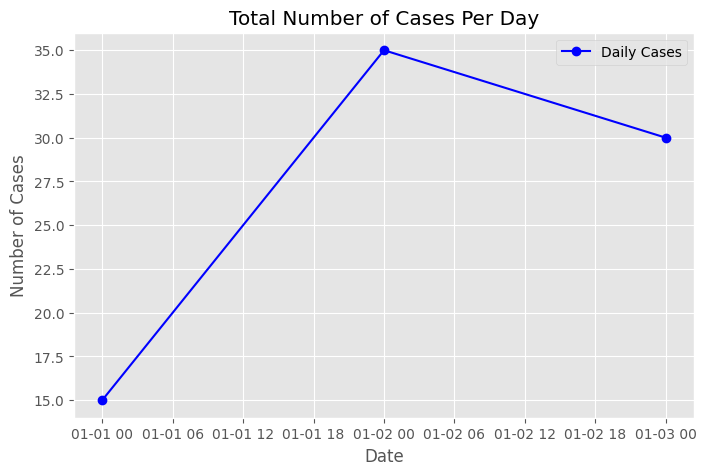

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Example dataset
data = {
    'date': ['2020-01-01','2020-01-02','2020-01-03'],
    'cases': [15, 35, 30],
    'deaths': [1, 3, 3],
    'recoveries': [2, 8, 10]
}

df = pd.DataFrame(data)

# Ensure date column is datetime type
df['date'] = pd.to_datetime(df['date'])

# Plot total cases per day
plt.figure(figsize=(8,5))
plt.plot(df['date'], df['cases'], marker='o', linestyle='-', color='blue', label='Daily Cases')
plt.title('Total Number of Cases Per Day')
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.grid(True)
plt.legend()
plt.show()


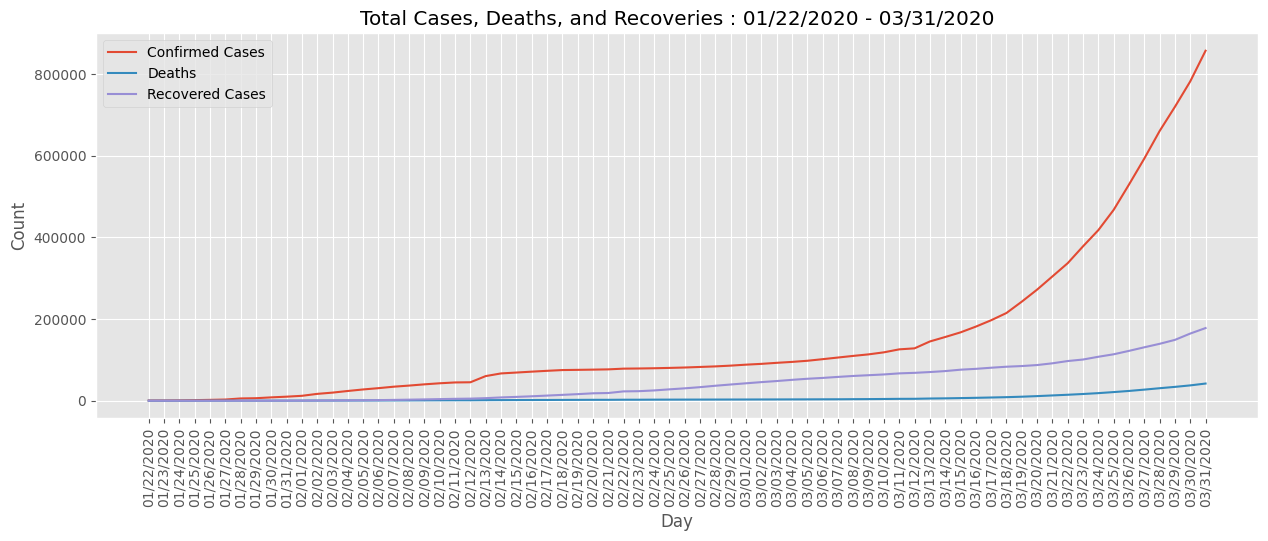

In [ ]:
plt.figure(figsize = [15,5])
plt.plot(df_date_tots['Confirmed'], label = "Confirmed Cases")
plt.plot(df_date_tots['Deaths'], label    = "Deaths")
plt.plot(df_date_tots['Recovered'], label = "Recovered Cases")

plt.legend()
plt.xlabel("Day")
plt.ylabel("Count")
plt.xticks(rotation = 90);
start_date = str(date_lst[0]);
fin_date   = str(date_lst[len(date_lst) -1])
plt.title("Total Cases, Deaths, and Recoveries : " + start_date + " - " + fin_date);


All of the three curves seem to be exponential (start of logistic curve). The confirmed cases was obviously higher than the deaths and recovered cases. The rate of the the recovered cases seems to be higher than that of the death curve.

### 6. Create one **plot** showing the trend of number of active cases and closed cases

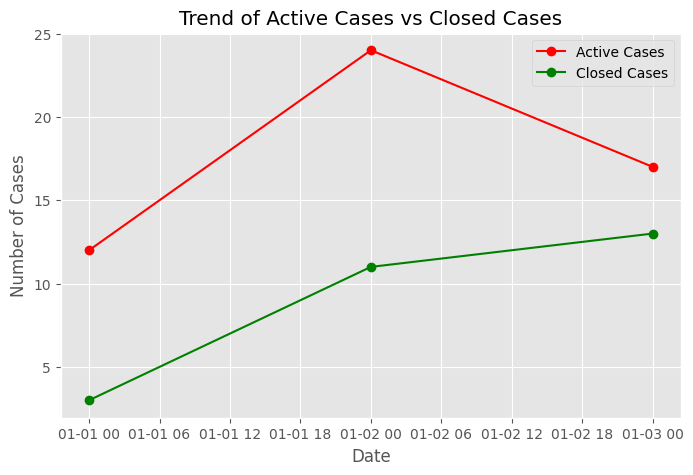

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Example dataset
data = {
    'date': ['2020-01-01','2020-01-02','2020-01-03'],
    'cases': [15, 35, 30],
    'deaths': [1, 3, 3],
    'recoveries': [2, 8, 10]
}

df = pd.DataFrame(data)
df['date'] = pd.to_datetime(df['date'])

# Add closed cases and active cases
df['closed_cases'] = df['deaths'] + df['recoveries']
df['active_cases'] = df['cases'] - df['closed_cases']

# Plot active vs closed cases
plt.figure(figsize=(8,5))
plt.plot(df['date'], df['active_cases'], marker='o', linestyle='-', color='red', label='Active Cases')
plt.plot(df['date'], df['closed_cases'], marker='o', linestyle='-', color='green', label='Closed Cases')
plt.title('Trend of Active Cases vs Closed Cases')
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.grid(True)
plt.legend()
plt.show()


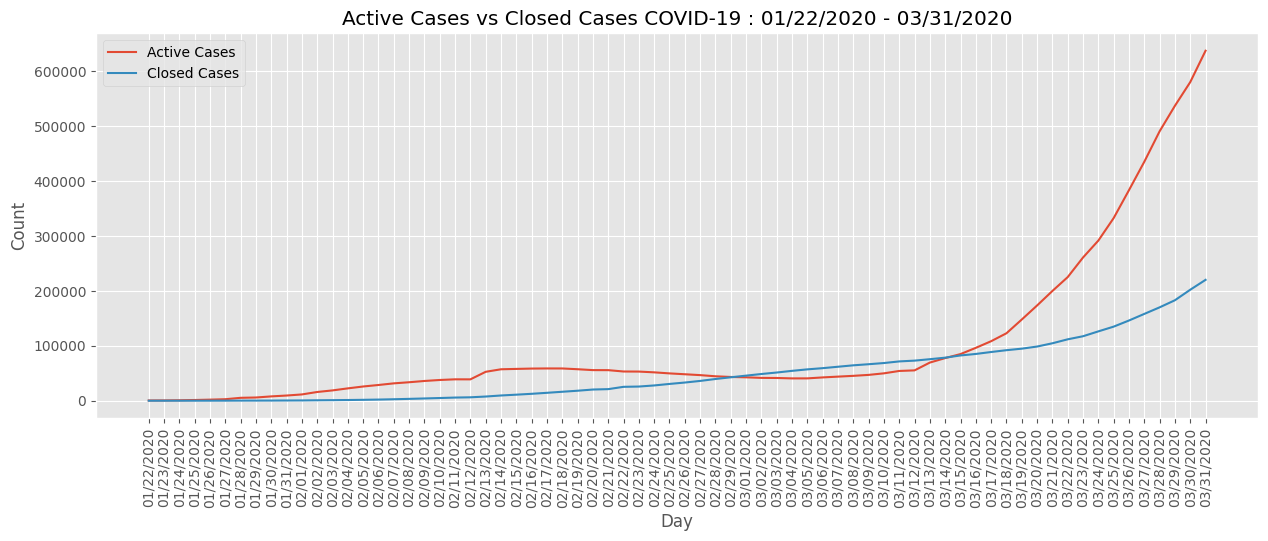

In [ ]:
plt.figure(figsize = [15,5])
plt.plot(df_date_tots['Active Cases'], label = "Active Cases")
plt.plot(df_date_tots['Closed Cases'], label = "Closed Cases")

plt.legend();
plt.xlabel("Day")
plt.ylabel("Count")
plt.xticks(rotation = 90)
start_date = str(date_lst[0])
fin_date   = str(date_lst[len(date_lst) -1])
plt.title("Active Cases vs Closed Cases COVID-19 : " + start_date + " - " + fin_date);

The number of active cases is higher than the number of closed cases as of yet.

### 7. Growth Factor

**Growth factor** is the factor by which a quantity multiplies itself over time. In the below cell, we calculate the GF of the confirmed, recovered and death cases.


In [ ]:
import pandas as pd

# Example dataset
data = {
    'date': ['2020-01-01','2020-01-02','2020-01-03','2020-01-04'],
    'confirmed': [10, 20, 40, 80],
    'recovered': [0, 5, 15, 30],
    'deaths': [1, 2, 4, 8]
}

df = pd.DataFrame(data)
df['date'] = pd.to_datetime(df['date'])

# Calculate Growth Factor (GF) = today's value / yesterday's value
df['GF_confirmed'] = df['confirmed'] / df['confirmed'].shift(1)
df['GF_recovered'] = df['recovered'] / df['recovered'].shift(1)
df['GF_deaths'] = df['deaths'] / df['deaths'].shift(1)

print(df)


        date  confirmed  recovered  deaths  GF_confirmed  GF_recovered  \
0 2020-01-01         10          0       1           NaN           NaN   
1 2020-01-02         20          5       2           2.0           inf   
2 2020-01-03         40         15       4           2.0           3.0   
3 2020-01-04         80         30       8           2.0           2.0   

   GF_deaths  
0        NaN  
1        2.0  
2        2.0  
3        2.0  


In [ ]:
growth_len_lst = len(date_lst) - 1
confirmed_lst = df_date_tots["Confirmed"]
death_lst = df_date_tots["Deaths"]
recovered_lst = df_date_tots["Recovered"]
confGF_lst = []
deathsGF_lst = []
recovGF_lst = []
for i in range(growth_len_lst):
    confirmedGF = confirmed_lst[i+1] / confirmed_lst[i]
    confGF_lst.append(confirmedGF)
    deathGF = death_lst[i+1] / death_lst[i]
    deathsGF_lst.append(deathGF)
    recoveredGF = recovered_lst[i+1] / recovered_lst[i]
    recovGF_lst.append(recoveredGF);


/tmp/ipython-input-3700421734.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  confirmedGF = confirmed_lst[i+1] / confirmed_lst[i]
/tmp/ipython-input-3700421734.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  deathGF = death_lst[i+1] / death_lst[i]
/tmp/ipython-input-3700421734.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  recoveredGF = recovered_lst[i+1] / recovered_lst[i]


### 8. Create one plot showing the Growth factor of confirmed, recovered and death cases wrt days

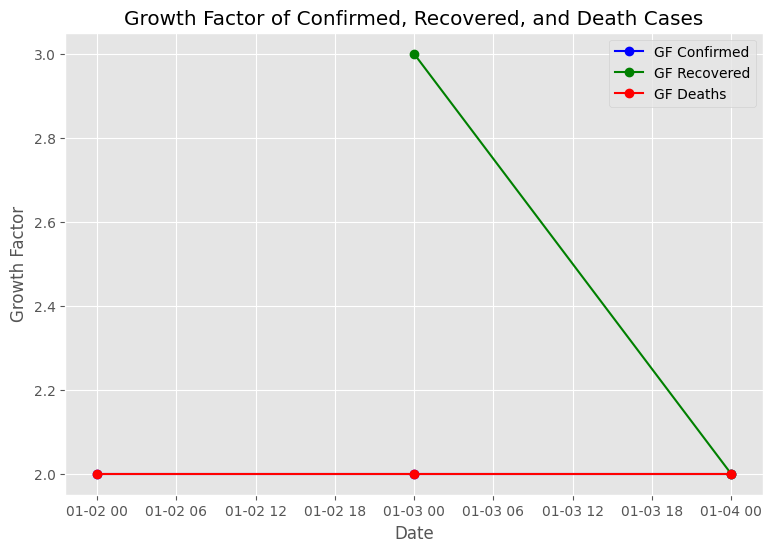

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Example dataset
data = {
    'date': ['2020-01-01','2020-01-02','2020-01-03','2020-01-04'],
    'confirmed': [10, 20, 40, 80],
    'recovered': [0, 5, 15, 30],
    'deaths': [1, 2, 4, 8]
}

df = pd.DataFrame(data)
df['date'] = pd.to_datetime(df['date'])

# Calculate Growth Factors
df['GF_confirmed'] = df['confirmed'] / df['confirmed'].shift(1)
df['GF_recovered'] = df['recovered'] / df['recovered'].shift(1)
df['GF_deaths'] = df['deaths'] / df['deaths'].shift(1)

# Plot Growth Factors
plt.figure(figsize=(9,6))
plt.plot(df['date'], df['GF_confirmed'], marker='o', linestyle='-', color='blue', label='GF Confirmed')
plt.plot(df['date'], df['GF_recovered'], marker='o', linestyle='-', color='green', label='GF Recovered')
plt.plot(df['date'], df['GF_deaths'], marker='o', linestyle='-', color='red', label='GF Deaths')

plt.title('Growth Factor of Confirmed, Recovered, and Death Cases')
plt.xlabel('Date')
plt.ylabel('Growth Factor')
plt.grid(True)
plt.legend()
plt.show()


Text(0.5, 1.0, 'Growth Factors of Confirmed, Death, and Recovered Cases COVID-19 : 01/22/2020 - 03/31/2020')

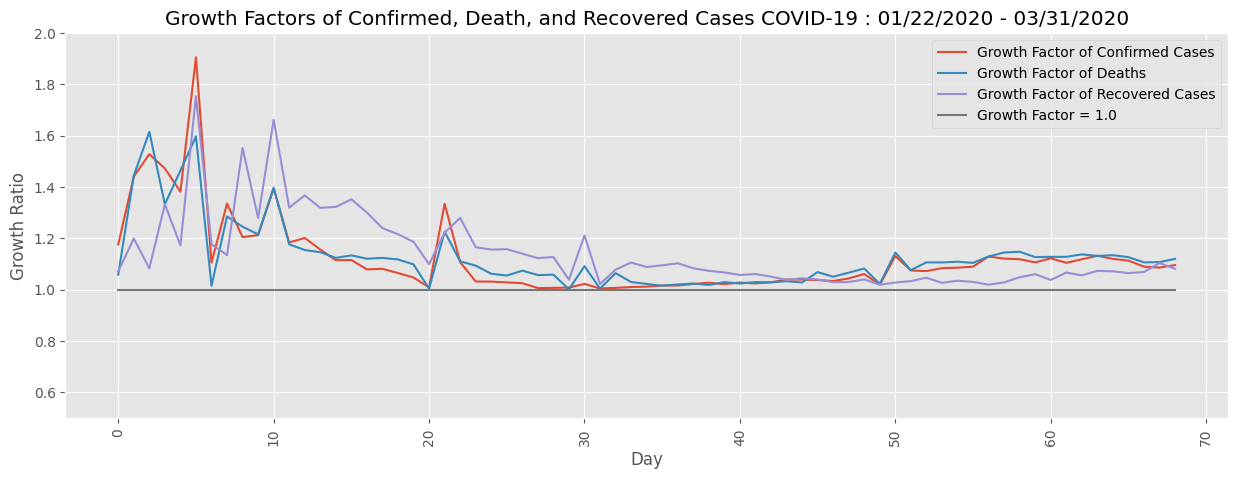

In [ ]:
plt.figure(figsize = [15,5])
plt.plot(confGF_lst, label = "Growth Factor of Confirmed Cases")
plt.plot(deathsGF_lst, label = "Growth Factor of Deaths")
plt.plot(recovGF_lst, label = "Growth Factor of Recovered Cases")
x = []
for i in range((growth_len_lst)):
    x.append(1)
plt.plot(x, label = "Growth Factor = 1.0")

#plt.grid()
plt.legend()
plt.xlabel("Day")
plt.ylabel("Growth Ratio")
plt.ylim(.5,2)
plt.xticks(rotation = 90)
start_date = str(date_lst[0])
fin_date   = str(date_lst[len(date_lst) -1])
plt.title("Growth Factors of Confirmed, Death, and Recovered Cases COVID-19 : " +start_date +" - " +fin_date)

# **Part 2 - Prediction Using Linear Regression**

#### To make our data to be compatible with *sklearn* format, create a new column called “Days since” which tracks the number of days since the initial date.

In [ ]:
days_since_lst = []
for i in range(len(date_lst)):
    days_since_lst.append(i)
df_date_tots["Days Since:"] = days_since_lst
df_date_tots = df_date_tots[["Days Since:", "Confirmed", "Deaths", "Recovered", "Active Cases", "Closed Cases"]]


### 8. Take the earliest 85% of the dates as **train** and the rest as **test**

In [ ]:
import pandas as pd

# Example dataset
data = {
    'date': ['2020-01-01','2020-01-02','2020-01-03','2020-01-04','2020-01-05','2020-01-06','2020-01-07'],
    'confirmed': [10, 20, 40, 80, 100, 120, 150],
    'recovered': [0, 5, 15, 30, 50, 70, 90],
    'deaths': [1, 2, 4, 8, 10, 12, 15]
}

df = pd.DataFrame(data)
df['date'] = pd.to_datetime(df['date'])

# Sort by date to ensure chronological order
df = df.sort_values('date').reset_index(drop=True)

# Calculate split index (85% train, 15% test)
split_index = int(len(df) * 0.85)

# Train = earliest 85% of dates
train = df.iloc[:split_index]

# Test = remaining 15% of dates
test = df.iloc[split_index:]

print("Train set:")
print(train)
print("\nTest set:")
print(test)


Train set:
        date  confirmed  recovered  deaths
0 2020-01-01         10          0       1
1 2020-01-02         20          5       2
2 2020-01-03         40         15       4
3 2020-01-04         80         30       8
4 2020-01-05        100         50      10

Test set:
        date  confirmed  recovered  deaths
5 2020-01-06        120         70      12
6 2020-01-07        150         90      15


In [ ]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

X = np.array(df_date_tots["Days Since:"]).reshape(-1,1)
y = np.array(df_date_tots["Confirmed"])


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.15,
                                                    shuffle = False)

### 9. We can try different regression and regularizations we have seen before

#### 9.1 Linear Regression

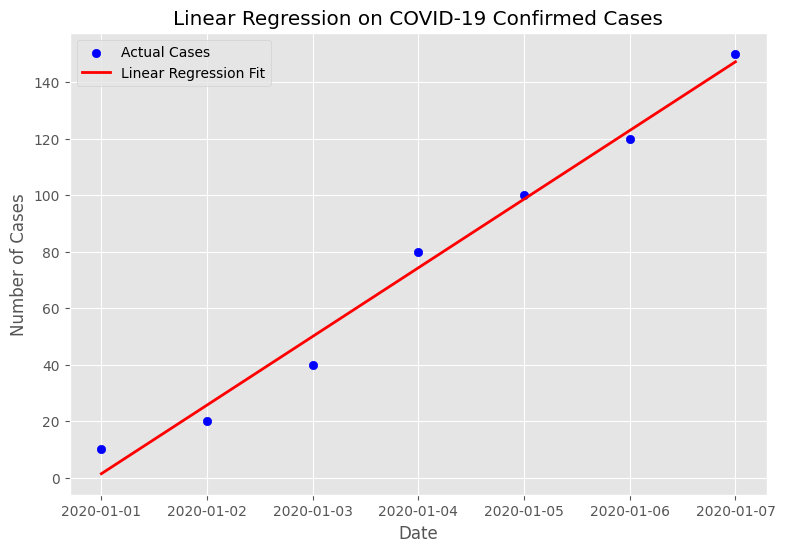

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np

# Example dataset
data = {
    'date': ['2020-01-01','2020-01-02','2020-01-03','2020-01-04','2020-01-05','2020-01-06','2020-01-07'],
    'confirmed': [10, 20, 40, 80, 100, 120, 150]
}

df = pd.DataFrame(data)
df['date'] = pd.to_datetime(df['date'])

# Convert dates to numeric values (ordinal)
df['date_ordinal'] = df['date'].map(lambda x: x.toordinal())

# Define X (date) and y (confirmed cases)
X = df[['date_ordinal']]
y = df['confirmed']

# Train Linear Regression model
model = LinearRegression()
model.fit(X, y)

# Predict values
df['predicted_cases'] = model.predict(X)

# Plot actual vs predicted
plt.figure(figsize=(9,6))
plt.scatter(df['date'], df['confirmed'], color='blue', label='Actual Cases')
plt.plot(df['date'], df['predicted_cases'], color='red', linewidth=2, label='Linear Regression Fit')
plt.title('Linear Regression on COVID-19 Confirmed Cases')
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
lin_model = LinearRegression(fit_intercept = False)
lin_model.fit(X_train, y_train)
test_lin_pred = lin_model.predict(X_test)
lin_pred = lin_model.predict(X)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


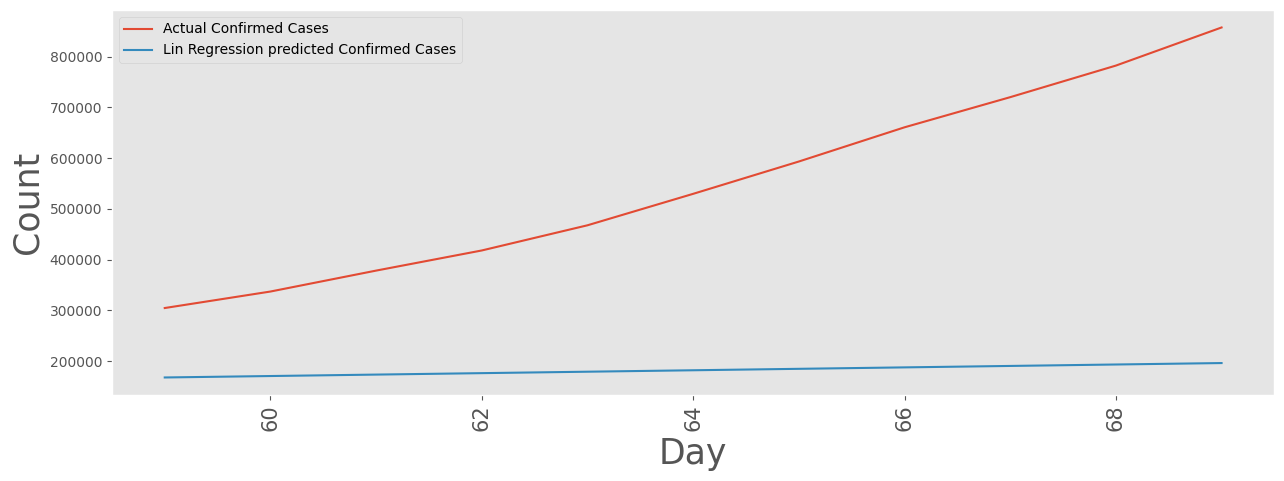

MAE: 181791.423099402
MSE: 33128805402.917187


In [ ]:
plt.figure(figsize = [15,5])
# plotting the actual values for the future days
plt.plot(X_test,
         y_test,
         label = "Actual Confirmed Cases")
# plotting the predicited values for the future days
plt.plot(X_test,
         test_lin_pred,
         label = "Lin Regression predicted Confirmed Cases")
plt.grid();
plt.legend();
plt.xlabel("Day", size = 25)
plt.ylabel("Count", size = 25)
plt.xticks(rotation = 90, size = 15)
plt.show()

print('MAE:', mean_absolute_error (test_lin_pred, X_test))
print('MSE:', mean_squared_error  (test_lin_pred, X_test))

#### Polynomial Regression

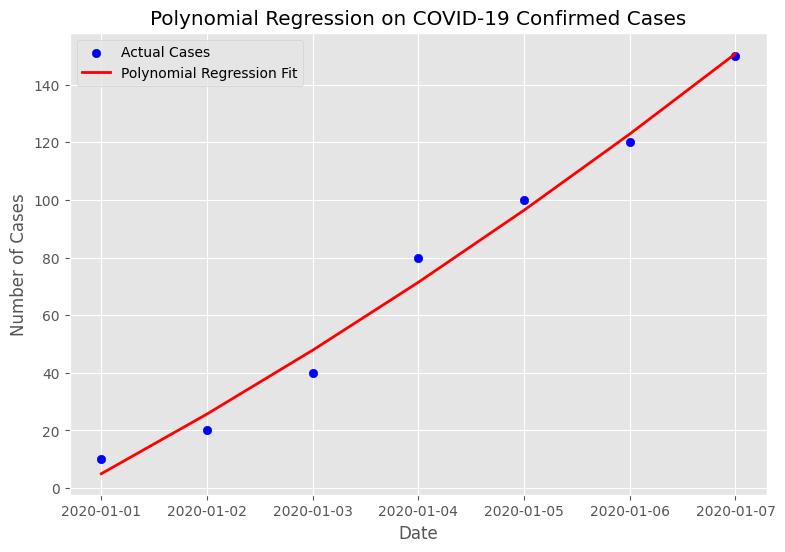

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import numpy as np

# Example dataset
data = {
    'date': ['2020-01-01','2020-01-02','2020-01-03','2020-01-04','2020-01-05','2020-01-06','2020-01-07'],
    'confirmed': [10, 20, 40, 80, 100, 120, 150]
}

df = pd.DataFrame(data)
df['date'] = pd.to_datetime(df['date'])

# Convert dates to numeric values (ordinal)
df['date_ordinal'] = df['date'].map(lambda x: x.toordinal())

# Define X and y
X = df[['date_ordinal']]
y = df['confirmed']

# Polynomial transformation (degree=2 or 3 works well for curves)
poly = PolynomialFeatures(degree=3)
X_poly = poly.fit_transform(X)

# Train Polynomial Regression model
model = LinearRegression()
model.fit(X_poly, y)

# Predict values
df['predicted_cases'] = model.predict(X_poly)

# Plot actual vs predicted
plt.figure(figsize=(9,6))
plt.scatter(df['date'], df['confirmed'], color='blue', label='Actual Cases')
plt.plot(df['date'], df['predicted_cases'], color='red', linewidth=2, label='Polynomial Regression Fit')
plt.title('Polynomial Regression on COVID-19 Confirmed Cases')
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
poly = PolynomialFeatures(degree=5)
poly_X_train = poly.fit_transform(X_train)
poly_X_test  = poly.fit_transform(X_test)
poly_X = poly.fit_transform(X)

In [ ]:
linear_model = LinearRegression(fit_intercept=False)
linear_model.fit(poly_X_train, y_train)
test_poly_pred = linear_model.predict(poly_X_test)
poly_pred = linear_model.predict(poly_X)


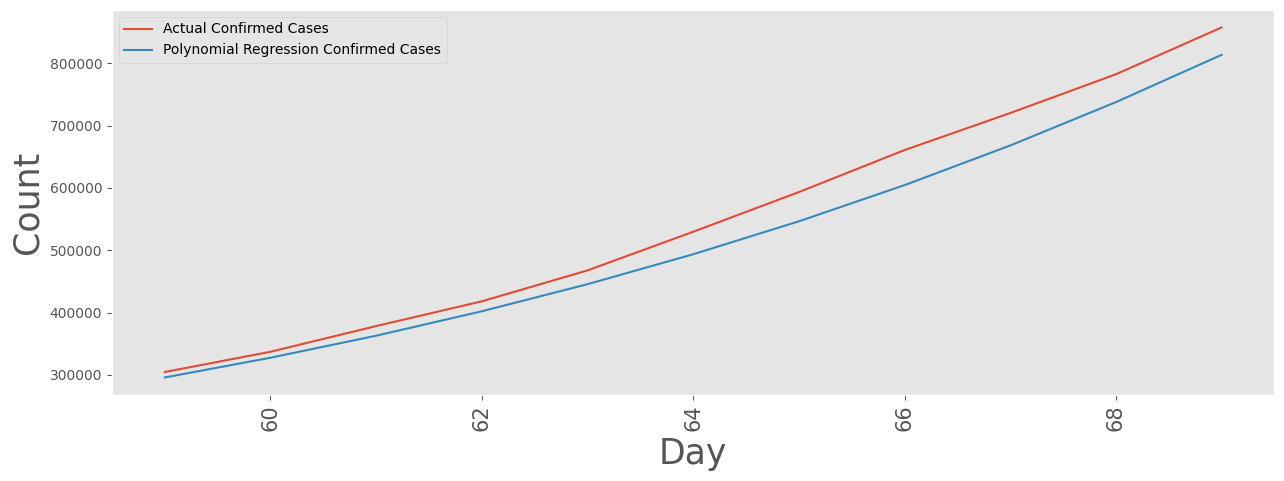

MAE: 31989.752428427022
MSE: 1314905574.5277777


In [ ]:
plt.figure(figsize = [15,5])

# plotting the actual values for the future days
plt.plot(X_test,
         y_test,
         label = "Actual Confirmed Cases")

# plotting the predicited values for the future days
plt.plot(X_test,
         test_poly_pred,
         label = "Polynomial Regression Confirmed Cases")
plt.grid();
plt.legend();
plt.xlabel("Day", size = 25)
plt.ylabel("Count", size = 25)
plt.xticks(rotation = 90, size = 15);
plt.show()

print('MAE:', mean_absolute_error(test_poly_pred, y_test))
print('MSE:',mean_squared_error(test_poly_pred, y_test))

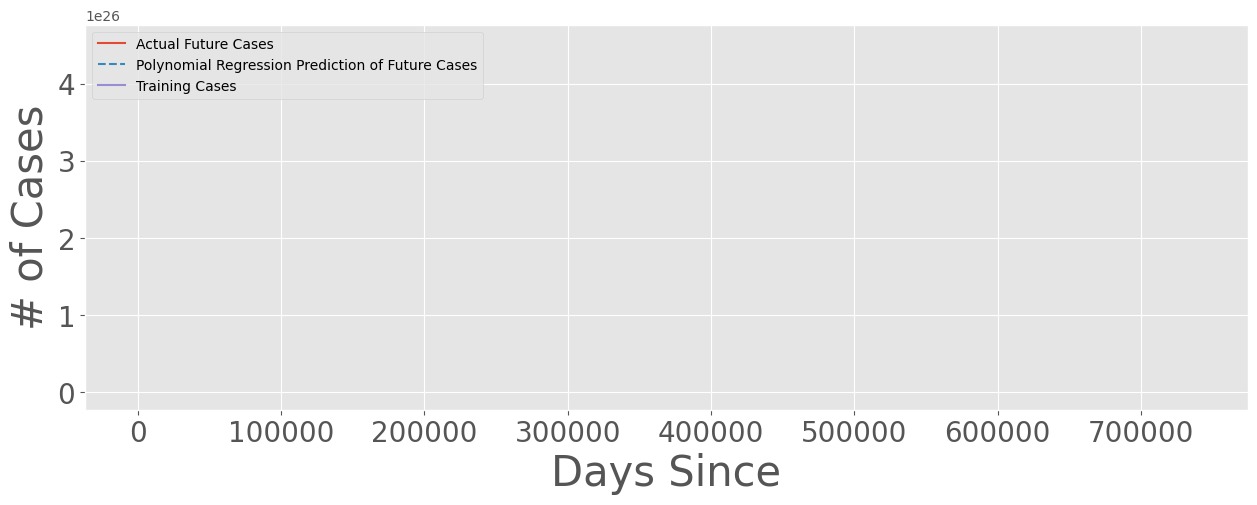

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(X,
         y,
         label = 'Actual Future Cases')

plt.plot(X,
         poly_pred,
         label = 'Polynomial Regression Prediction of Future Cases',
         linestyle = "dashed")

plt.plot(X_train,
         y_train,
         label = 'Training Cases')

plt.xlabel('Days Since', size = 30)
plt.ylabel('# of Cases', size = 30)
plt.legend()
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

### 9.2 Ridge Regression

/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.3419e-26): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)


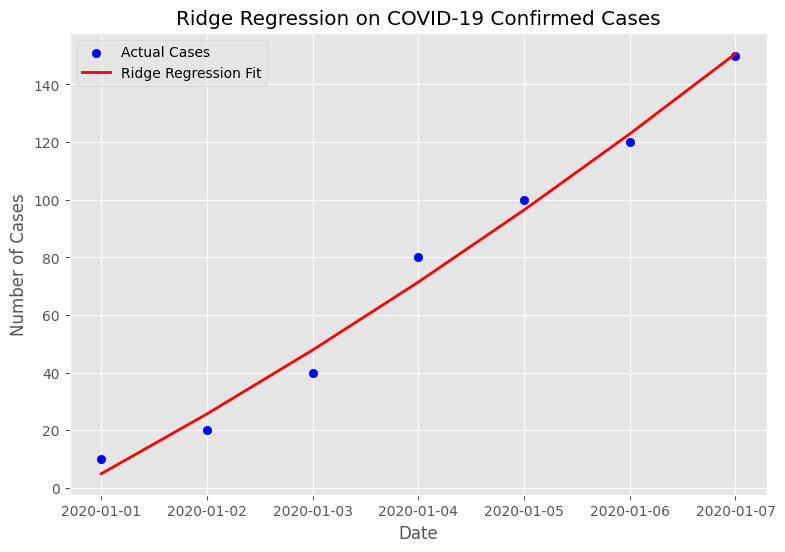

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import numpy as np

# Example dataset
data = {
    'date': ['2020-01-01','2020-01-02','2020-01-03','2020-01-04','2020-01-05','2020-01-06','2020-01-07'],
    'confirmed': [10, 20, 40, 80, 100, 120, 150]
}

df = pd.DataFrame(data)
df['date'] = pd.to_datetime(df['date'])

# Convert dates to numeric values (ordinal)
df['date_ordinal'] = df['date'].map(lambda x: x.toordinal())

# Define X and y
X = df[['date_ordinal']]
y = df['confirmed']

# Ridge Regression with polynomial features (degree=3 for non-linear trend)
model = make_pipeline(PolynomialFeatures(degree=3), Ridge(alpha=1.0))
model.fit(X, y)

# Predict values
df['predicted_cases'] = model.predict(X)

# Plot actual vs predicted
plt.figure(figsize=(9,6))
plt.scatter(df['date'], df['confirmed'], color='blue', label='Actual Cases')
plt.plot(df['date'], df['predicted_cases'], color='red', linewidth=2, label='Ridge Regression Fit')
plt.title('Ridge Regression on COVID-19 Confirmed Cases')
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
tol      = [1e-4, 1e-3, 1e-2]
alpha_1  = [1e-7, 1e-6, 1e-5, 1e-4]
alpha_2  = [1e-7, 1e-6, 1e-5, 1e-4]
lambda_1 = [1e-7, 1e-6, 1e-5, 1e-4]
lambda_2 = [1e-7, 1e-6, 1e-5, 1e-4]

bayesian_grid = {'tol': tol,
                 'alpha_1': alpha_1,
                 'alpha_2' : alpha_2,
                 'lambda_1': lambda_1,
                 'lambda_2' : lambda_2 }

bayesian = BayesianRidge(fit_intercept=False)
bayesian_search = RandomizedSearchCV(bayesian,
                                     bayesian_grid,
                                     scoring='neg_mean_squared_error',
                                     cv=3,
                                     return_train_score=True,
                                     n_jobs=-1,
                                     n_iter=40,
                                     verbose=1)

bayesian_search.fit(X_train, y_train)

print(bayesian_search.best_params_)

Fitting 3 folds for each of 40 candidates, totalling 120 fits
{'tol': 0.0001, 'lambda_2': 1e-07, 'lambda_1': 0.0001, 'alpha_2': 1e-07, 'alpha_1': 1e-07}


In [ ]:
y_test_ridge_pred = bayesian_search.predict(X_test);
y_ridge_pred = bayesian_search.predict(X);

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but BayesianRidge was fitted without feature names
  warnings.warn(


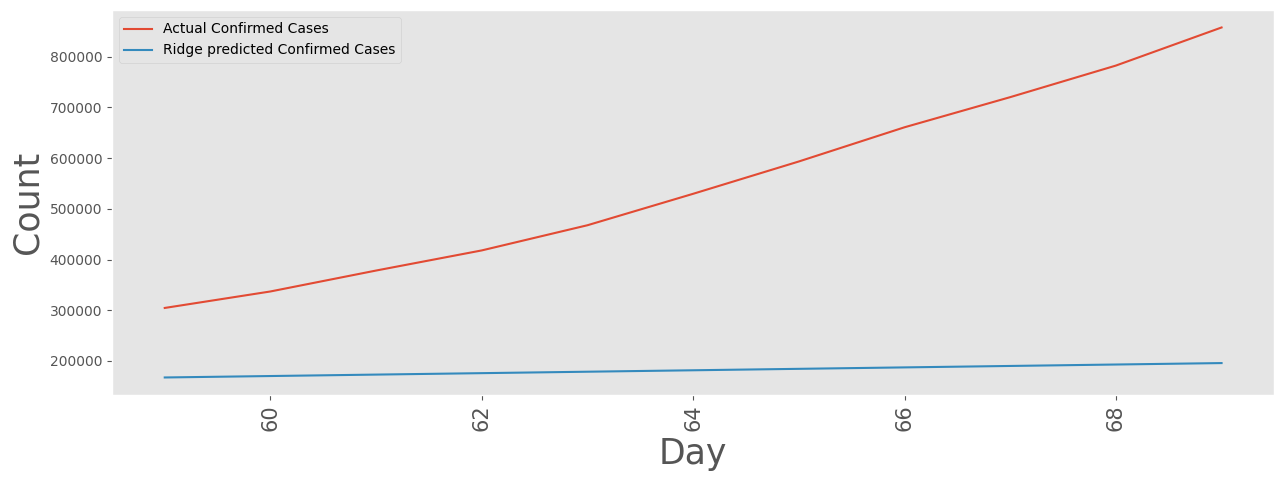

MAE: 181588.76120723973
MSE: 33054982293.94005


In [ ]:
plt.figure(figsize = [15,5])

# plotting the actual values for the future days
plt.plot(X_test,
         y_test,
         label = "Actual Confirmed Cases")

# plotting the predicited values for the future days
plt.plot(X_test,
         y_test_ridge_pred,
         label = "Ridge predicted Confirmed Cases")
plt.grid();
plt.legend();
plt.xlabel("Day", size = 25)
plt.ylabel("Count", size = 25)
plt.xticks(rotation = 90, size = 15);
plt.show()

print('MAE:', mean_absolute_error (y_test_ridge_pred, X_test))
print('MSE:', mean_squared_error  (y_test_ridge_pred, X_test))

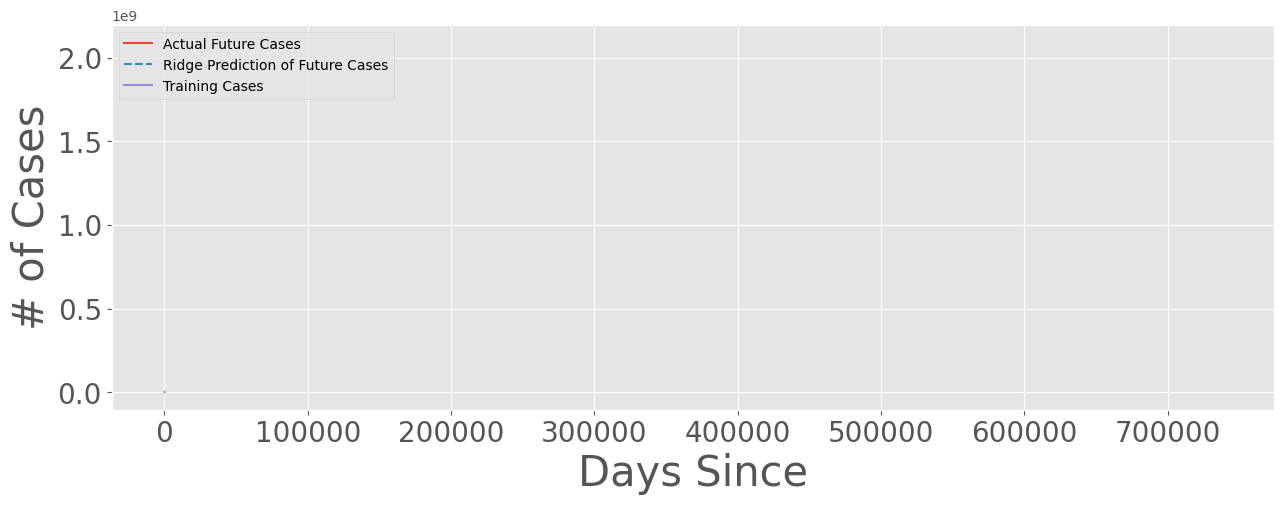

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(X,
         y,
         label = 'Actual Future Cases')
plt.plot(X,
         y_ridge_pred,
         label = 'Ridge Prediction of Future Cases',
         linestyle = "dashed")
plt.plot(X_train,
         y_train,
         label = 'Training Cases')

#plt.title('# of Coronavirus Cases Over Time', size=30)
plt.xlabel('Days Since', size = 30)
plt.ylabel('# of Cases', size = 30)
plt.legend()
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

#### Polynomial Ridge Regression

/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.3419e-26): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)


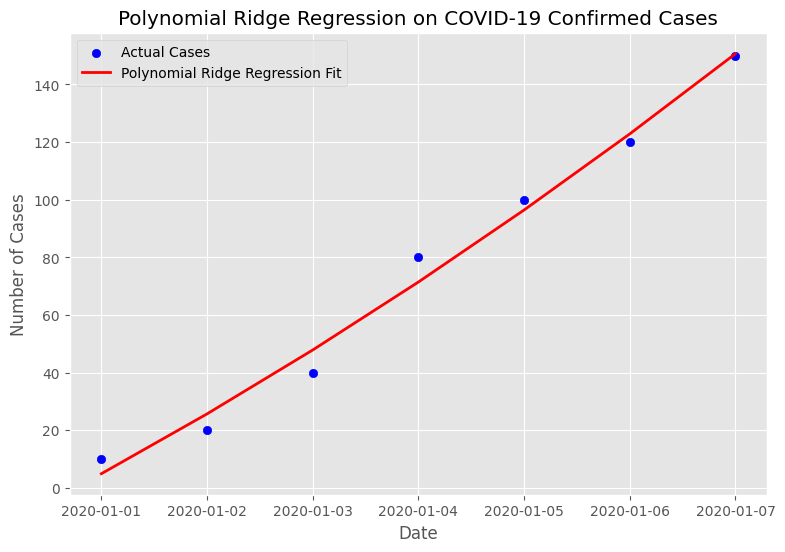

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Example dataset
data = {
    'date': ['2020-01-01','2020-01-02','2020-01-03','2020-01-04','2020-01-05','2020-01-06','2020-01-07'],
    'confirmed': [10, 20, 40, 80, 100, 120, 150]
}

df = pd.DataFrame(data)
df['date'] = pd.to_datetime(df['date'])

# Convert dates to numeric values (ordinal)
df['date_ordinal'] = df['date'].map(lambda x: x.toordinal())

# Define X and y
X = df[['date_ordinal']]
y = df['confirmed']

# Polynomial Ridge Regression (degree=3, alpha=1.0)
model = make_pipeline(PolynomialFeatures(degree=3), Ridge(alpha=1.0))
model.fit(X, y)

# Predict values
df['predicted_cases'] = model.predict(X)

# Plot actual vs predicted
plt.figure(figsize=(9,6))
plt.scatter(df['date'], df['confirmed'], color='blue', label='Actual Cases')
plt.plot(df['date'], df['predicted_cases'], color='red', linewidth=2, label='Polynomial Ridge Regression Fit')
plt.title('Polynomial Ridge Regression on COVID-19 Confirmed Cases')
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
bayesian_search_poly = RandomizedSearchCV(bayesian,
                                     bayesian_grid,
                                     scoring='neg_mean_squared_error',
                                     cv=3,
                                     return_train_score=True,
                                     n_jobs=-1,
                                     n_iter=40,
                                     verbose=1)


In [ ]:
bayesian_search_poly.fit(poly_X_train, y_train);
print(bayesian_search_poly.best_params_)

Fitting 3 folds for each of 40 candidates, totalling 120 fits
{'tol': 0.0001, 'lambda_2': 0.0001, 'lambda_1': 0.0001, 'alpha_2': 0.0001, 'alpha_1': 1e-07}


In [ ]:
bayesian_poly_confirmed = bayesian_search_poly.best_estimator_
test_poly_bayesian_pred = bayesian_poly_confirmed.predict(poly_X_test)
bayesian_poly_pred = bayesian_poly_confirmed.predict(poly_X)

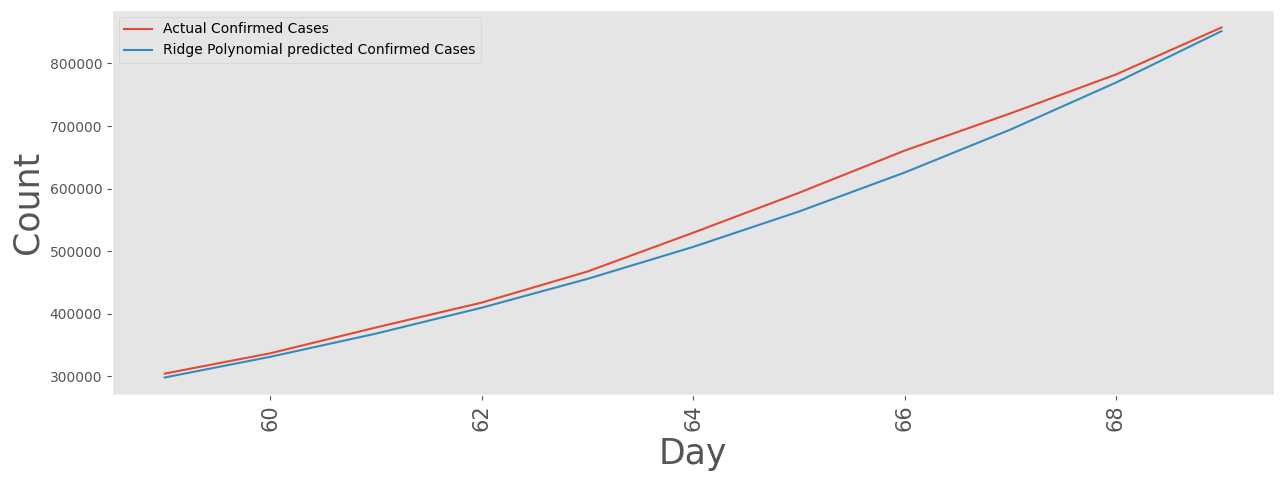

MAE: 15796.104432945065
MSE: 352565817.8337257


In [ ]:
plt.figure(figsize = [15,5])

# plotting the actual values for the future days
plt.plot(X_test,
         y_test,
         label = "Actual Confirmed Cases")

# plotting the predicited values for the future days
plt.plot(X_test,
         test_poly_bayesian_pred,
         label = "Ridge Polynomial predicted Confirmed Cases")
plt.grid();
plt.legend();
plt.xlabel("Day", size = 25)
plt.ylabel("Count", size = 25)
plt.xticks(rotation = 90, size = 15)
plt.show()

print ('MAE:', mean_absolute_error(test_poly_bayesian_pred, y_test))
print ('MSE:', mean_squared_error (test_poly_bayesian_pred, y_test))

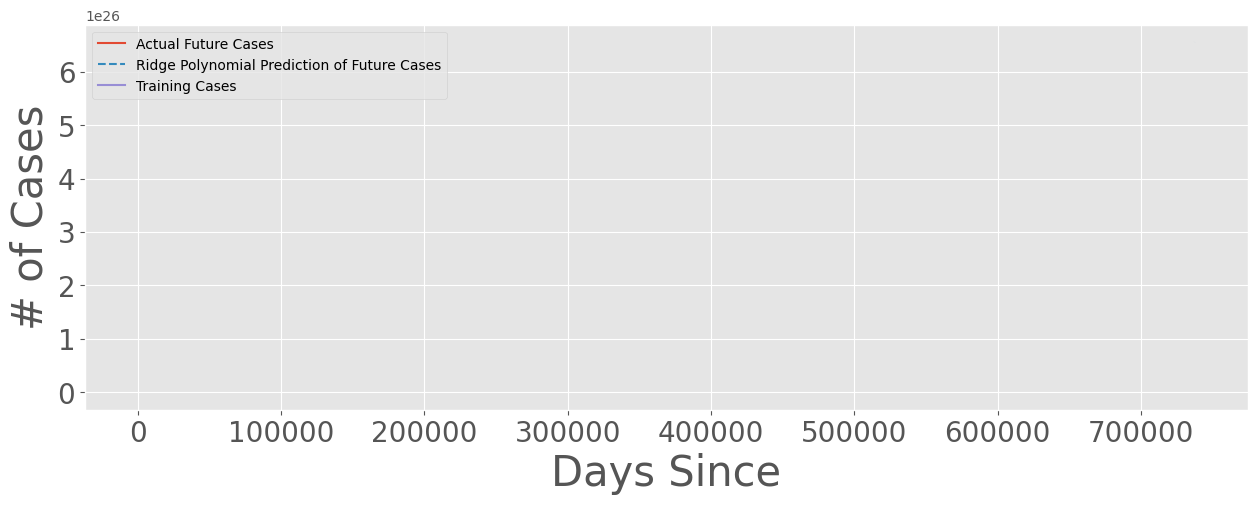

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(X,
         y,
         label = 'Actual Future Cases')
plt.plot(X,
         bayesian_poly_pred,
         label = 'Ridge Polynomial Prediction of Future Cases',
         linestyle = "dashed")
plt.plot(X_train,
         y_train,
         label = 'Training Cases')

#plt.title('# of Coronavirus Cases Over Time', size=30)
plt.xlabel('Days Since', size = 30)
plt.ylabel('# of Cases', size = 30)
#plt.grid()
plt.legend()
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [ ]:
print("Polynomial Regression ")
print('\tMAE:', mean_absolute_error(test_poly_pred, y_test))
print('\tMSE:',mean_squared_error(test_poly_pred, y_test))

print("\nRidge Polynomial Regression ")
print ('\tMAE:', mean_absolute_error(test_poly_bayesian_pred, y_test))
print ('\tMSE:', mean_squared_error (test_poly_bayesian_pred, y_test))

Polynomial Regression 
	MAE: 31989.752428427022
	MSE: 1314905574.5277777

Ridge Polynomial Regression 
	MAE: 15796.104432945065
	MSE: 352565817.8337257


From Mean Absolute Error and Mean Squared Error values, Ridge Polynomial Regression Model seems to be the best model.